### МОДУЛЬ 15. ПРОЕКТ МОДУЛЯ (HW-03)(часть 1)

In [1]:
import pandas as pd
import os
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt 
%matplotlib inline

### Данные

In [2]:
path = r'F:\SkillFactory\Временные ряды'
train = pd.read_csv(os.path.join(path,'train_.csv'))

In [133]:
df = train[train.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1617 non-null   object 
 1   unit_sales  1617 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.4+ KB


**Восстановление недостающих данных временного ряда: предварительный анализ**

In [134]:
# Восстановим недостающие значения временного ряда
# чтобы было хорошо видно на графике, недостающие значения установим в -1000
dti = pd.date_range(start="2013-01-01", end="2017-08-14", freq="D")
omiss = pd.DataFrame({'date':list(set(dti.astype('str'))-set(df['date'])),'unit_sales':-1000})
df = pd.concat([df,omiss])

In [135]:
omiss['date']

0     2016-09-12
1     2016-09-05
2     2016-10-21
3     2016-10-19
4     2016-08-31
         ...    
65    2016-09-06
66    2016-10-17
67    2016-08-22
68    2016-09-27
69    2016-09-25
Name: date, Length: 70, dtype: object

In [136]:
df.sort_values(by='date', inplace=True)
print(df)

            date  unit_sales
0     2013-01-01    2511.619
1     2013-01-02    5316.224
2     2013-01-03    4442.913
3     2013-01-04    4844.354
4     2013-01-05    5817.526
...          ...         ...
1612  2017-08-10   10781.434
1613  2017-08-11   22800.841
1614  2017-08-12   15090.753
1615  2017-08-13    8570.598
1616  2017-08-14    8244.854

[1687 rows x 2 columns]


In [137]:
df.set_index('date',inplace=True)

In [138]:
df.tail(10)

,unit_sales
date,
2017-08-05,9910.015
2017-08-06,8064.109
2017-08-07,7527.348
2017-08-08,6025.029
2017-08-09,9707.858
2017-08-10,10781.434
2017-08-11,22800.841
2017-08-12,15090.753
2017-08-13,8570.598


In [139]:
df[df.unit_sales==-1000]

,unit_sales
date,
2013-12-25,-1000.0
2014-12-25,-1000.0
2015-12-25,-1000.0
2016-08-22,-1000.0
2016-08-23,-1000.0
...,...
2016-10-23,-1000.0
2016-10-24,-1000.0
2016-10-25,-1000.0


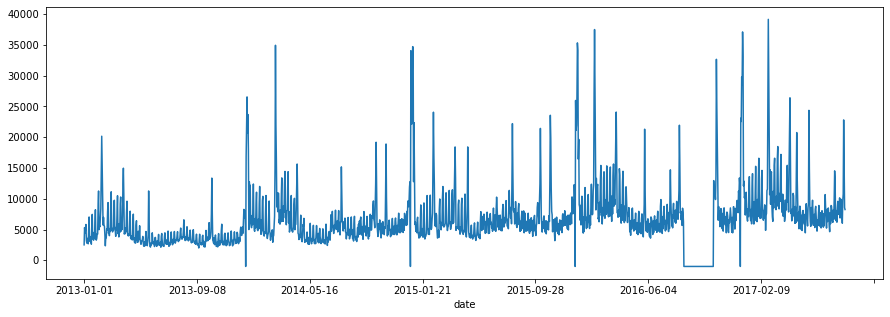

In [140]:
_ = df['unit_sales'].plot(figsize=(15, 5))

**70 недостающих значений хорошо заметны в: 2013,2015 и основная часть в 2016 годах**

In [143]:
df = train[train.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()
# Восстановим недостающие значения временного ряда
dti = pd.date_range(start="2013-01-01", end="2017-08-14", freq="D")
omiss = pd.DataFrame({'date':list(set(dti.astype('str'))-set(df['date'])),'unit_sales':np.nan})
df = pd.concat([df,omiss])
df.sort_values(by='date', inplace=True)

**Для восстановления данных можно использовать полиномиальную интерполяцию:**

In [144]:
df['unit_sales'].interpolate(method='polynomial',order=2, inplace=True)

In [145]:
df.set_index('date',inplace=True)

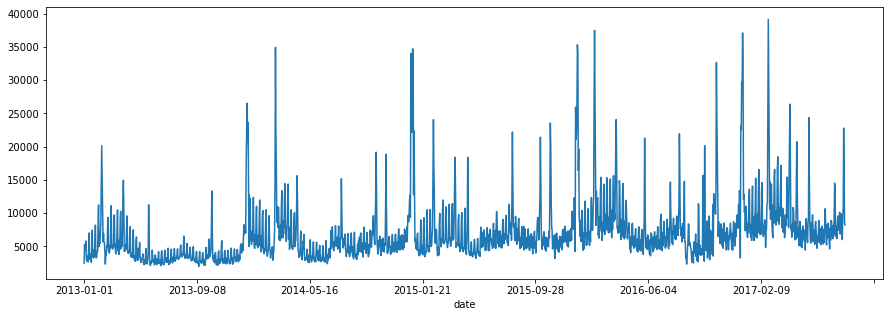

In [147]:
_ = df['unit_sales'].plot(figsize=(15, 5))

In [235]:
holiday = pd.read_csv(os.path.join(path,'holidays_events.csv'))

In [236]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [237]:
holiday.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [238]:
holiday[holiday['locale_name']=='Santa Elena']

,date,type,locale,locale_name,description,transferred
24,2012-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
77,2013-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
140,2014-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
194,2015-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
279,2016-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
335,2017-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False


In [239]:
holiday[holiday['locale']=='Local'].locale_name.unique()

array(['Manta', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda',
       'Latacunga', 'Machala', 'Santo Domingo', 'El Carmen', 'Cayambe',
       'Esmeraldas', 'Ambato', 'Ibarra', 'Quevedo', 'Quito', 'Loja',
       'Salinas', 'Guayaquil'], dtype=object)

In [240]:
stores = pd.read_csv(os.path.join(path,'stores.csv'))

In [241]:
name = stores[stores['store_nbr']==25]['state']

In [242]:
name.values[0]

'Santa Elena'

In [243]:
holiday[holiday['locale_name']==name.values[0]]

,date,type,locale,locale_name,description,transferred
24,2012-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
77,2013-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
140,2014-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
194,2015-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
279,2016-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
335,2017-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False


**Число транзакций по магазину**

In [244]:
transactions = pd.read_csv(os.path.join(path,'transactions.csv'))

In [245]:
df_trans = transactions[transactions.store_nbr==25]

In [246]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1615 entries, 0 to 83458
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1615 non-null   object
 1   store_nbr     1615 non-null   int64 
 2   transactions  1615 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 50.5+ KB


In [247]:
df_trans.drop(columns=['store_nbr'], inplace=True)

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [248]:
df = pd.merge(df, df_trans, how='left')

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1617 entries, 0 to 1616
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1617 non-null   object 
 1   unit_sales    1617 non-null   float64
 2   transactions  1614 non-null   float64
dtypes: float64(2), object(1)
memory usage: 50.5+ KB


In [250]:
df['transactions'].fillna(df['transactions'].mode()[0], inplace=True)

In [251]:
df.head(5)

,date,unit_sales,transactions
0,2013-01-01,2511.619,770.0
1,2013-01-02,5316.224,1038.0
2,2013-01-03,4442.913,887.0
3,2013-01-04,4844.354,1054.0
4,2013-01-05,5817.526,1355.0


### Сезонная декомпозиция

In [254]:
df = train[train.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()

In [255]:
# приводим индексы к стандарту pd.Datetime, чтобы потом это можно было скормить seasonal_decompose
df = df.set_index(pd.DatetimeIndex(df['date'])) 
df.drop(['date'], axis = 1, inplace = True)
df.head() # снова проверяем, что все в порядке. вообще проверять данные на каждом шаге кода - хорошая привычка

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


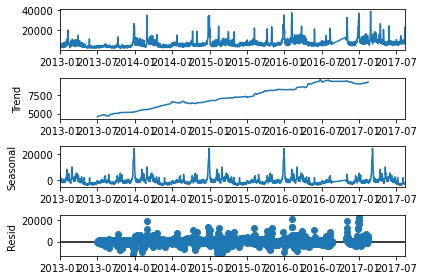

In [256]:
# применяем seasonal_decompose
# эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
decomposition = seasonal_decompose(df, model='additive',period=365) 
decomposition.plot()
pyplot.show() # любуемся результатом

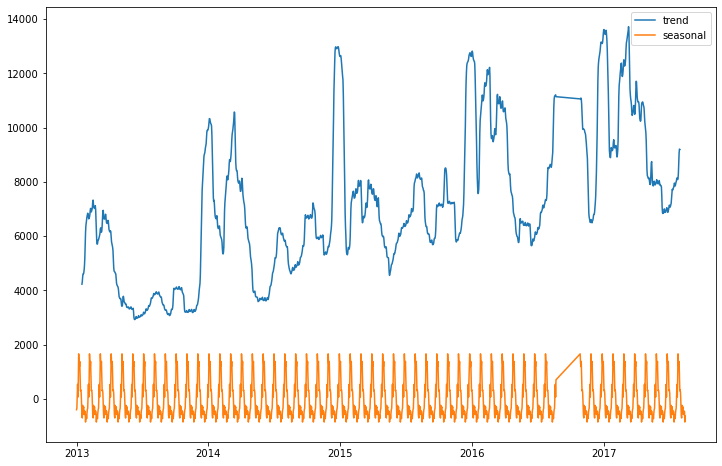

In [257]:
decomposition = seasonal_decompose(df.unit_sales.values, period=30) 

pyplot.figure(figsize=(12, 8))
pyplot.plot(df.index, decomposition.trend, label='trend')
pyplot.plot(df.index, decomposition.seasonal, label='seasonal')
#pyplot.plot(df.index, decomposition.resid, label='residual')
#pyplot.plot(df.index, df['unit_sales'], label='data')
pyplot.legend();

In [258]:
'''
df = df.asfreq('D').fillna(df.median())
decomposition = seasonal_decompose(df.unit_sales.values, period=30) 

pyplot.figure(figsize=(12, 8))
pyplot.plot(df.index, decomposition.trend, label='trend')
pyplot.plot(df.index, decomposition.seasonal, label='seasonal')
#pyplot.plot(df.index, decomposition.resid, label='residual')
#pyplot.plot(df.index, df['unit_sales'], label='data')
pyplot.legend();
'''

"\ndf = df.asfreq('D').fillna(df.median())\ndecomposition = seasonal_decompose(df.unit_sales.values, period=30) \n\npyplot.figure(figsize=(12, 8))\npyplot.plot(df.index, decomposition.trend, label='trend')\npyplot.plot(df.index, decomposition.seasonal, label='seasonal')\n#pyplot.plot(df.index, decomposition.resid, label='residual')\n#pyplot.plot(df.index, df['unit_sales'], label='data')\npyplot.legend();\n"

**Вывод:** При декомпозиции временного ряда четко прослеживается годовой тренд и месячная сезонность.

### Тест Дики-Фуллера

In [259]:
def print_diki_fuller(test):
    
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
        print ('ряд не стационарен')
    else:
        print ('ряд стационарен')

In [260]:
test = adfuller(df['unit_sales'])
print_diki_fuller(test)    

adf:  -4.842069581392824
p-value:  4.515537136238424e-05
Critical values:  {'1%': -3.4344668334240493, '5%': -2.8633583388041717, '10%': -2.5677380487468597}
ряд стационарен


### Расчет факторов

In [261]:
df = train[train.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()

#### Постройте скользящее среднее c окном 5.

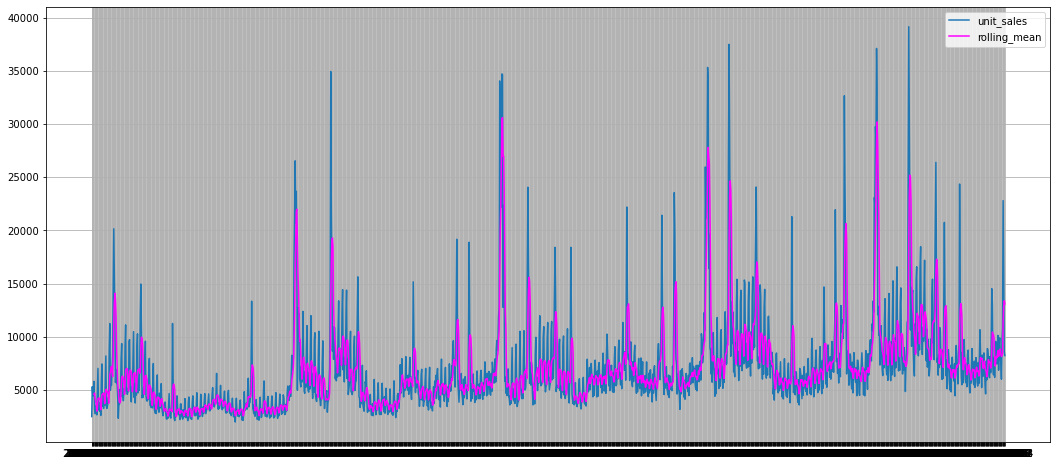

In [262]:
df['rolling_mean'] = df.unit_sales.rolling(window=5).mean()
## визуализируем
N = 5
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
# ax.plot(df.ts, df.rolling_mean_10, c='r') ## оконное среднее
ax.plot(df.date, df['rolling_mean'],  c='magenta') ## оконное среднее
#ax.plot(df.ts, df['rolling_ema_'  + str(N)],  c='magenta') ## оконное среднее
ax.legend(['unit_sales', 'rolling_mean'])
ax.grid()

#### Постройте скользящее квадратическое отклонение c окном 5.

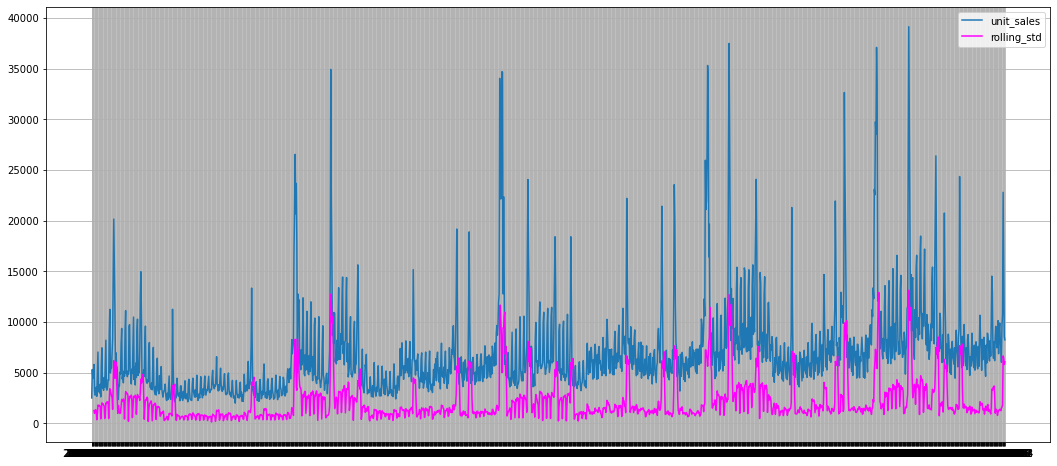

In [263]:
df['rolling_std']  = df.unit_sales.rolling(window=5).std()
## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные

ax.plot(df.date, df['rolling_std'],  c='magenta') ## оконное среднее

ax.legend(['unit_sales', 'rolling_std'])
ax.grid()

#### Постройте так называемые линии Боллинджера с окном в 30 (если этого позволяет выбранный ряд): добавьте к скользящему среднему скользящее стандартное отклонение, умноженное на три — верхняя линия Боллинджера; отнимите от скользящего среднего скользящее стандартное отклонение, умноженное на три — нижняя линия Боллинджера.

In [264]:
df['rolling_mean'] = df.unit_sales.rolling(window=30).mean()
df['rolling_std']  = df.unit_sales.rolling(window=30).std()
df['top_bollinger'] = df['rolling_mean'] + 3*df['rolling_std'] 
df['bottom_bollinger'] = df['rolling_mean'] - 3*df['rolling_std'] 

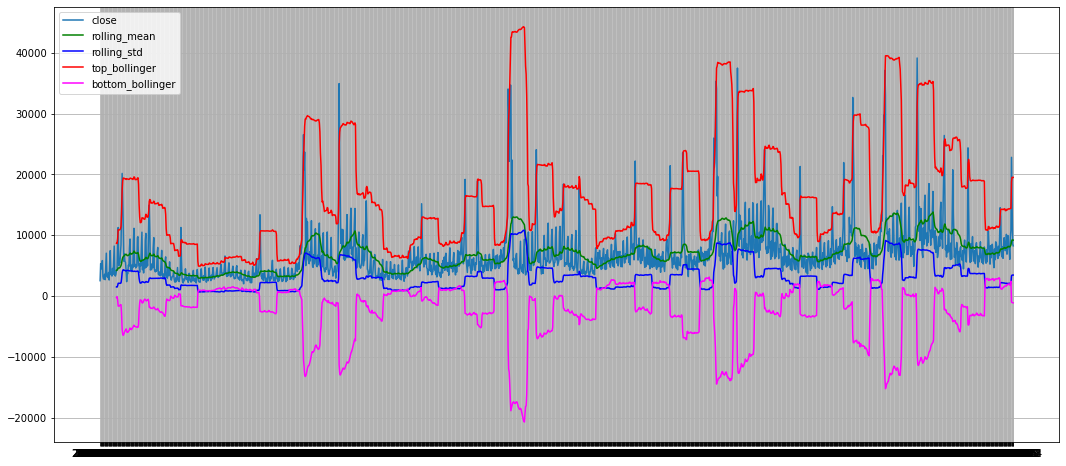

In [265]:
## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
ax.plot(df.date, df.rolling_mean,  c='g') 
ax.plot(df.date, df.rolling_std,  c='b') 
ax.plot(df.date, df.top_bollinger,  c='r') 
ax.plot(df.date, df.bottom_bollinger,  c='magenta') 

ax.legend(['close', 'rolling_mean', 'rolling_std', 'top_bollinger', 'bottom_bollinger'])
ax.grid()

#### Постройте оконное среднее с окном в 10 точек.

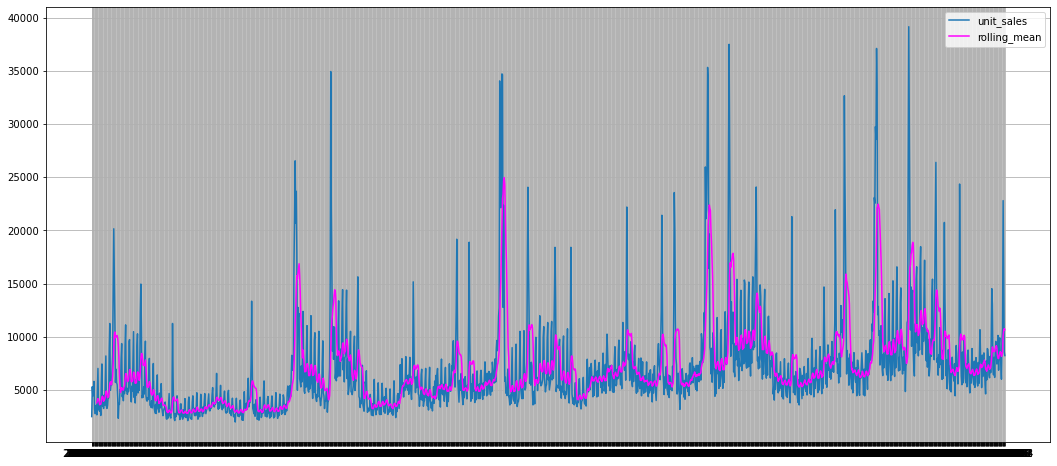

In [266]:
df['rolling_mean'] = df.unit_sales.rolling(window=10).mean()
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
ax.plot(df.date, df['rolling_mean'],  c='magenta') ## оконное среднее
ax.legend(['unit_sales', 'rolling_mean'])
ax.grid()

#### Постройте экспоненциально среднее с окном в 7 точек (span=7).

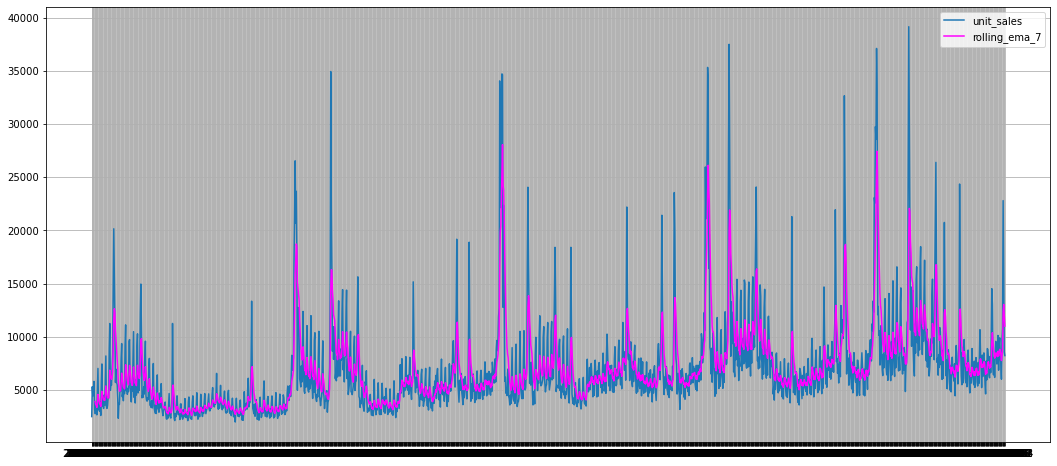

In [267]:
N=7
df['rolling_ema_' + str(N)] = df.unit_sales.ewm(min_periods=N, span=N).mean()
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
ax.plot(df.date, df['rolling_ema_' + str(N)],  c='magenta') ## оконное среднее
ax.legend(['unit_sales', 'rolling_ema_' + str(N)])
ax.grid()

#### Напишите свою скользящую функцию, которая будет являться средним арифметическим между максимальным и минимальным значением unit_sales, используя окно 10.

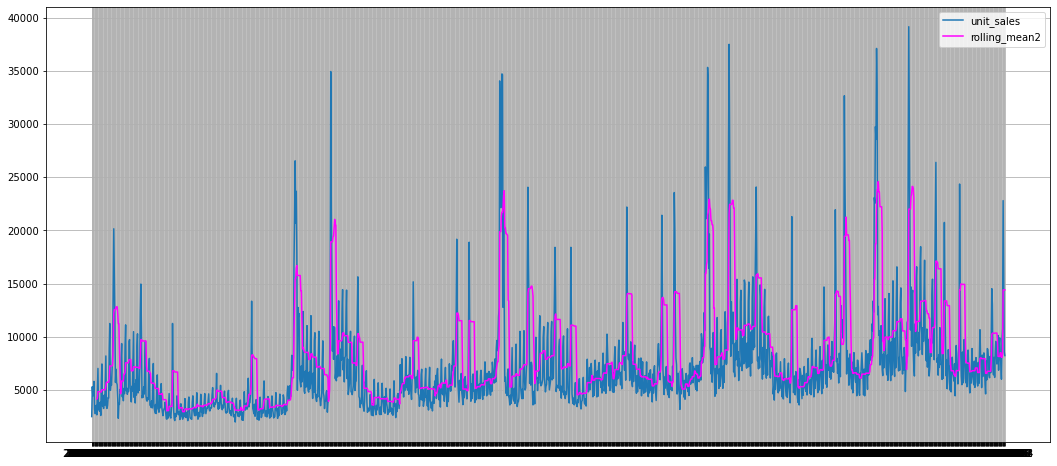

In [268]:
def myMean(value):
    return (max(value)+min(value))/2
N = 10
## делаем оконное среднее с окном в 10 точек
#df['rolling_min'] = df.unit_sales.rolling(window=N).min()
#df['rolling_max']  = df.unit_sales.rolling(window=N).max()
df['rolling_mean2']  = df.unit_sales.rolling(window=N).apply(myMean, raw=False)

## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
ax.plot(df.date, df['rolling_mean2'],  c='magenta') ## оконное среднее
ax.legend(['unit_sales', 'rolling_mean2'])
ax.grid()

#### Постройте скользящее среднее с окном 50 и экспоненциальное скользящее среднее с окном 10 (span=10). Укажите индексы датафрейма, на которых одно скользящее пересекается с другим. Для этого вычтите из одно скользящего среднего другое, возьмите знак этой разности (np.sign), продифференциируйте его (diff()) и оставьте только те точки, где результат дифференциирования не равен нулю.

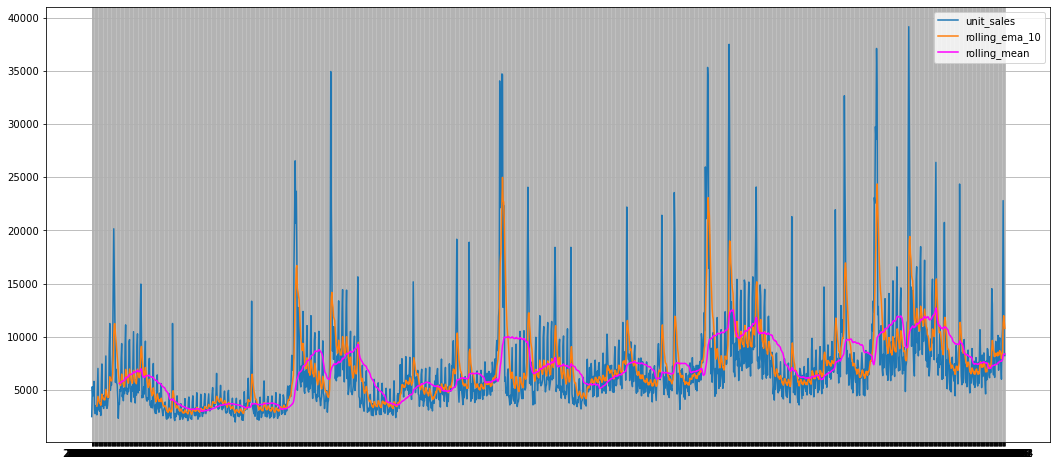

In [269]:
def myMax(value):
    return max(value)

## делаем оконное среднее с окном в 10 точек
df['rolling_mean'] = df.unit_sales.rolling(window=50).mean()
df['rolling_ema_10'] = df.unit_sales.ewm(min_periods=10, span=10).mean()
df['intersection']  = (np.sign(df['rolling_mean'] - df['rolling_ema_10']))

## визуализируем
## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
ax.plot(df.date, df.rolling_ema_10) ## исходные данные
ax.plot(df.date, df['rolling_mean'],  c='magenta') ## оконное среднее
ax.legend(['unit_sales', 'rolling_ema_10', 'rolling_mean'])
ax.grid()

In [270]:
np.diff(df['intersection']).nonzero()

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   51,   55,   59,   62,   66,
          68,   73,   74,   80,   81,   85,   96,  142,  146,  179,  180,
         185,  187,  192,  237,  241,  243,  273,  292,  304,  305,  332,
         337,  338,  378,  380,  381,  421,  453,  471,  472,  521,  522,
         534,  537,  540,  580,  611,  613,  618,  628,  629,  630,  632,
         655,  666,  673,  696,  698,  702,  703,  709,  736,  771,  782,
         785,  787,  792,  795,  799,  801,  806,  808,  813,  815,  818,
         829,  847,  851,  882,  923,  924,  937,  938,  957,  960,  961,
        1002, 1019, 1029, 1039, 1078, 1101, 1126, 1136, 1140, 1144, 1148,
        1150, 1155, 1156, 1174, 1186, 

#### Получите лаговые факторы с 7-го по 10-й предыдущих дня (лаг7, лаг8, лаг9, лаг10) и отобразите на графике.

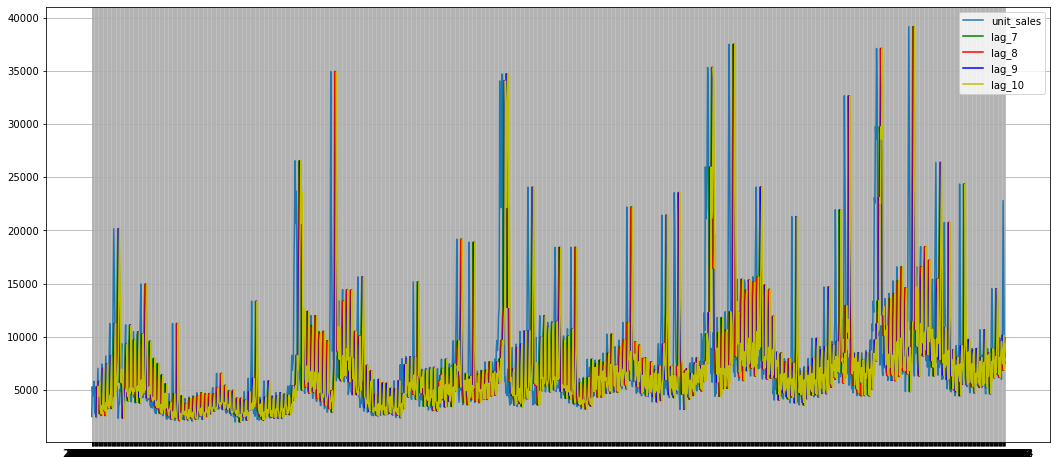

In [271]:
for i in range(7,11):
    df['lag_{}'.format(i)] = df.unit_sales.shift(i)


## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
ax.plot(df.date, df['lag_' + str(7)],  c='g') 
ax.plot(df.date, df['lag_' + str(8)],  c='r') 
ax.plot(df.date, df['lag_' + str(9)],  c='b') 
ax.plot(df.date, df['lag_' + str(10)],  c='y') 
#ax.plot(df.ts, df['lag_' + str(11)],  c='magenta') 
ax.legend(['unit_sales', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
ax.grid()

# ARIMA

In [272]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict
%matplotlib inline

In [273]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

**Выберите продукт с номером 103501 (item_nbr) и приведите данные к виду временного ряда с группировкой по дате и агрегацией .sum()['unit_sales'].**

In [274]:
path = r'F:\SkillFactory\Временные ряды'
train = pd.read_csv(os.path.join(path,'train_.csv'))
df = train[train.item_nbr==103501].groupby("date")['unit_sales'].sum().reset_index()

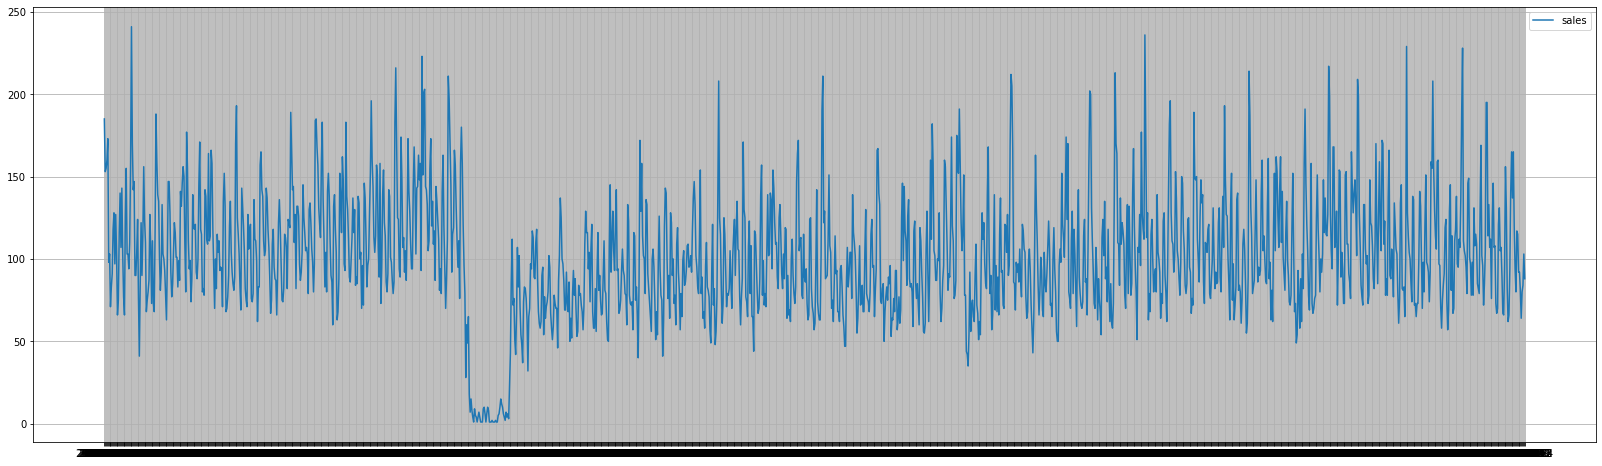

In [275]:
## визуализируем
f, ax = plt.subplots(1, 1, figsize=(28, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные

ax.legend(['sales'])
ax.grid()

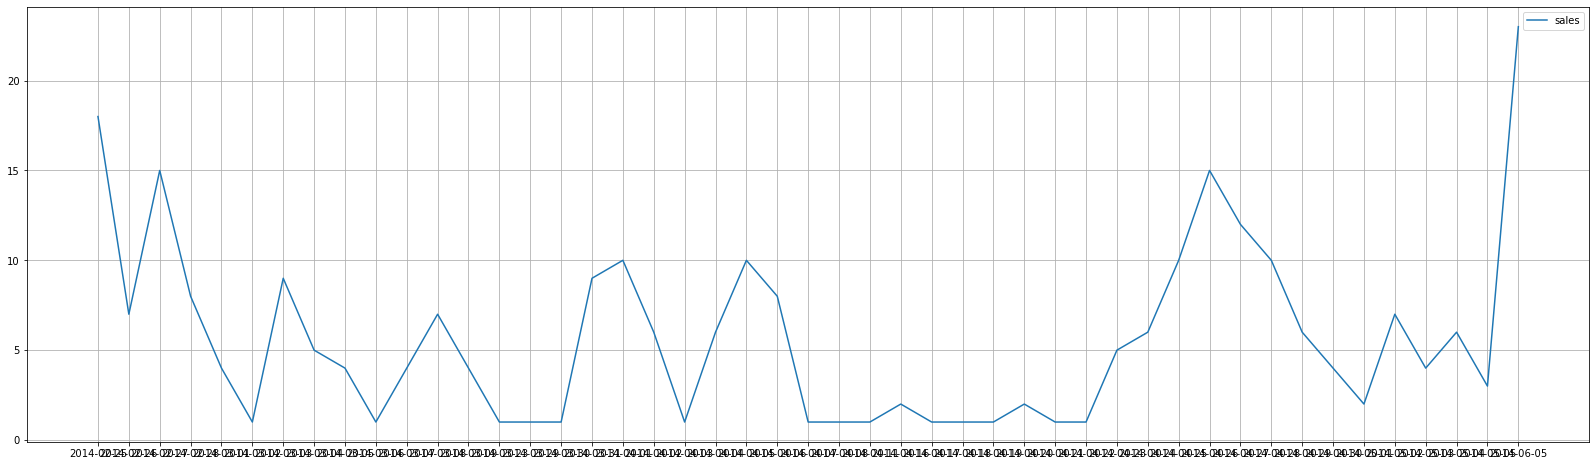

In [276]:
#df[df['unit_sales']<25]
## визуализируем выбросы временного ряда
f, ax = plt.subplots(1, 1, figsize=(28, 8))
ax.plot(df[df['unit_sales']<25].date, df[df['unit_sales']<25]['unit_sales']) ## исходные данные

ax.legend(['sales'])
ax.grid()

In [277]:
df.describe()

,unit_sales
count,1624.000000
mean,101.393473
std,37.010062
min,1.000000
25%,78.000000
50%,97.500000
75%,122.000000
max,241.000000


In [278]:
# Заменим выбросы временного ряда средним значений предыдущего и последующего года в этот день:

df['mean'] = pd.DataFrame((df['unit_sales'].shift(365)+df['unit_sales'].shift(-365))/2)
df['unit_sales'] = np.where((df['unit_sales'] >25), df['unit_sales'], df['mean'])

<AxesSubplot:>

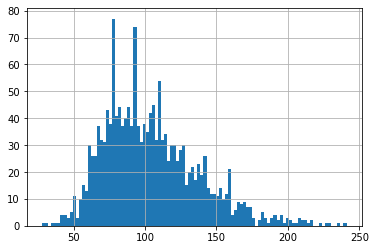

In [279]:
df.unit_sales.hist(bins=100)

**Распределение близкое к нормальному с вытянутым правым хвостом**

<AxesSubplot:>

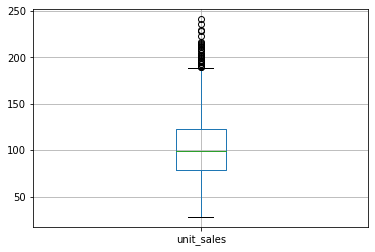

In [282]:
df.boxplot(column=['unit_sales'])

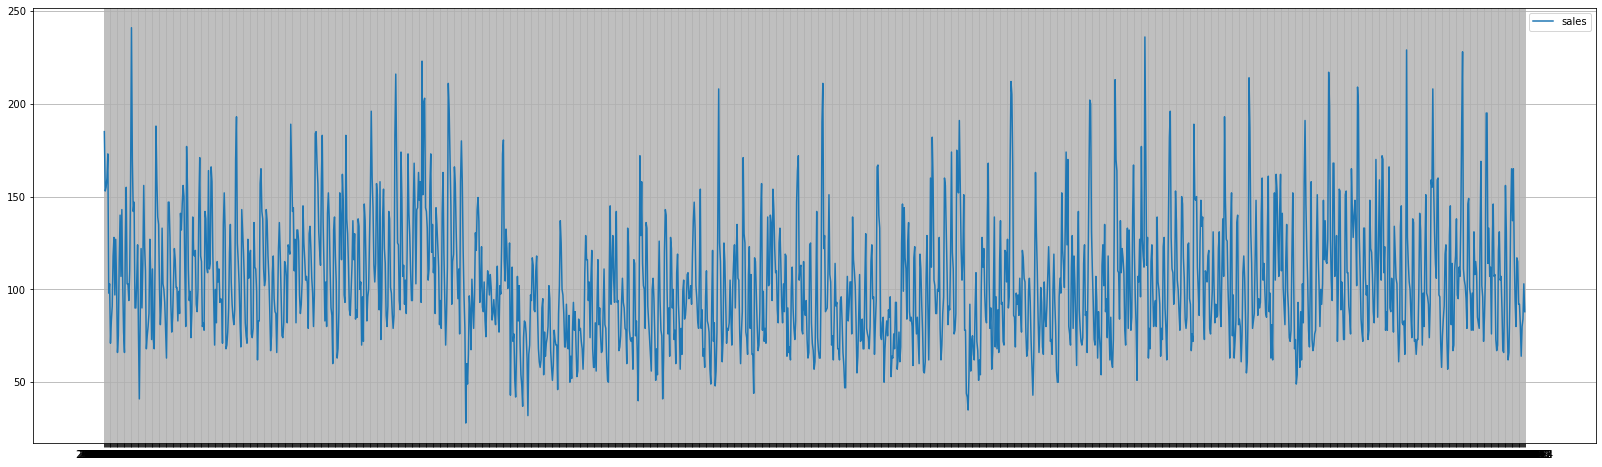

In [284]:
## визуализируем: ряд выглядит значительно лучше
f, ax = plt.subplots(1, 1, figsize=(28, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные

ax.legend(['sales'])
ax.grid()

**Тест Адфуллера для проверки стационарных временных рядов**

In [285]:
top1 = train[train.item_nbr == 103501 ]
top1['date'] = pd.to_datetime(top1['date'])
top1['year'] = top1['date'].dt.year
unit_sales_by_date = top1.groupby('date').sum()['unit_sales']

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [286]:
from statsmodels.tsa.stattools import adfuller

X = unit_sales_by_date.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -4.153752
p-value: 0.000788
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject Ho - Time Series is Stationary


**Постройте прогноз методом скользящего среднего с окном 6, как в ноутбуке выше. Посчитайте метрики MSE, MAE, MAPE.**

(1618,) (1624,)
mean_squared_error 1140.1606750446365
mean_absolute_error 26.6741862381541
mean_absolute_percentage_error 0.3268887968119734


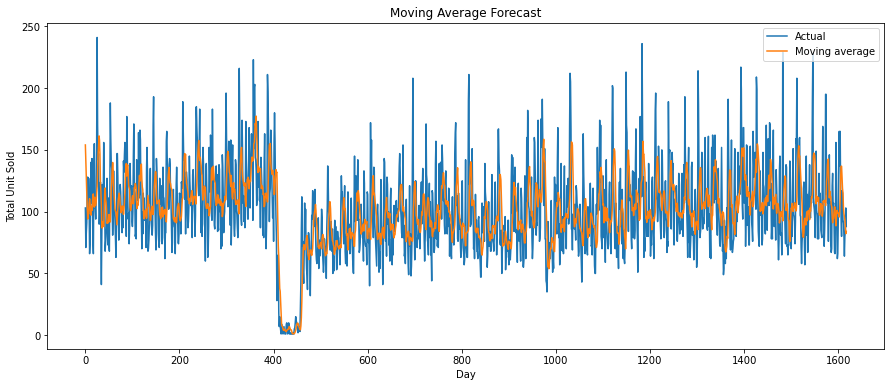

In [287]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6
moving_avg = moving_average_forecast(unit_sales_by_date,moving_average_days )# 

print(moving_avg.shape,unit_sales_by_date.shape)

print("mean_squared_error",mean_squared_error(unit_sales_by_date.values[moving_average_days:], moving_avg))
print("mean_absolute_error",mean_absolute_error(unit_sales_by_date.values[moving_average_days:], moving_avg))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(unit_sales_by_date.values[moving_average_days:], moving_avg))


plt.figure(figsize=(15,6))

plt.plot(unit_sales_by_date.values[moving_average_days:], label="Actual")
plt.plot(moving_avg, label="Moving average")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

**Сделайте лаги с 1 по 6.**

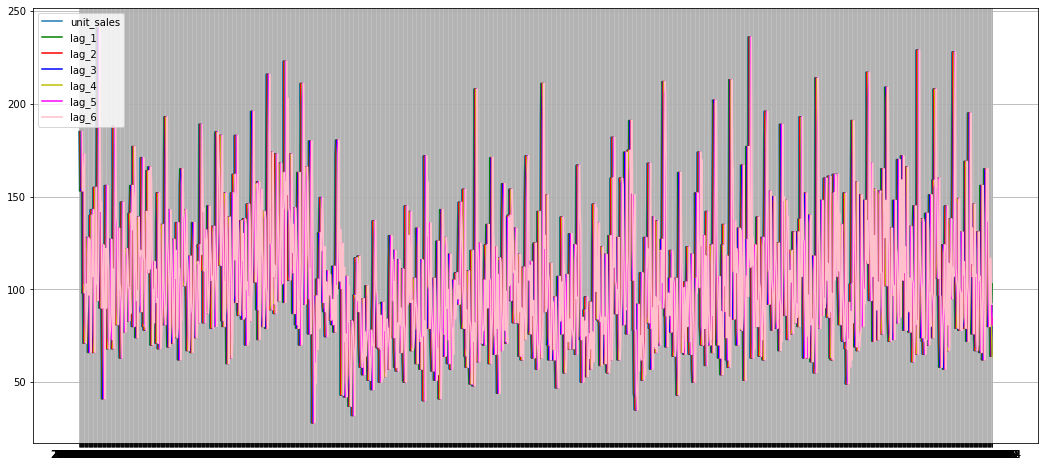

In [288]:
for i in range(1,7):
    df['lag_{}'.format(i)] = df.unit_sales.shift(i)


## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df.date, df.unit_sales) ## исходные данные
ax.plot(df.date, df['lag_' + str(1)],  c='g') 
ax.plot(df.date, df['lag_' + str(2)],  c='r') 
ax.plot(df.date, df['lag_' + str(3)],  c='b') 
ax.plot(df.date, df['lag_' + str(4)],  c='y') 
ax.plot(df.date, df['lag_' + str(5)],  c='magenta') 
ax.plot(df.date, df['lag_' + str(6)],  c='pink') 
ax.legend(['unit_sales', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6'])
ax.grid()

**Разделите выборку на тренировочную и тестовую таким образом, чтобы в тест попадал весь 2017 год.**

In [289]:
df = pd.DataFrame()

for i in range(1,7):
    df['lag_{}'.format(i)] = unit_sales_by_date.shift(i)
    
df["y"] = unit_sales_by_date

lag_value = 6
df.dropna(inplace=True)

x_train, y_train = df['2013':'2016'].iloc[:,0:lag_value].values, df['2013':'2016'].iloc[:,lag_value:].values
x_test, y_test = df['2017'].iloc[:,0:lag_value].values, df['2017'].iloc[:,lag_value:].values
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1393, 6) (1393, 1)
(225, 6) (225, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  if sys.path[0] == '':


In [290]:
df.head(5)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,y
date,,,,,,,
2013-01-08,98.0,173.0,160.0,155.0,153.0,185.0,103.0
2013-01-09,103.0,98.0,173.0,160.0,155.0,153.0,71.0
2013-01-10,71.0,103.0,98.0,173.0,160.0,155.0,83.0
2013-01-11,83.0,71.0,103.0,98.0,173.0,160.0,91.0
2013-01-12,91.0,83.0,71.0,103.0,98.0,173.0,118.0


**Сделайте прогноз линейной регрессией, посчитайте значения метрик MSE, MAE, MAPE.**

[[ 0.65082231 -0.05879179 -0.02734075 -0.01144045 -0.0576629   0.31276881]]
[19.07113259]
mean_squared_error 911.1979968961676
mean_absolute_error 22.954034103675752
mean_absolute_percentage_error 0.20689848227601437
RMSE: 30.186056


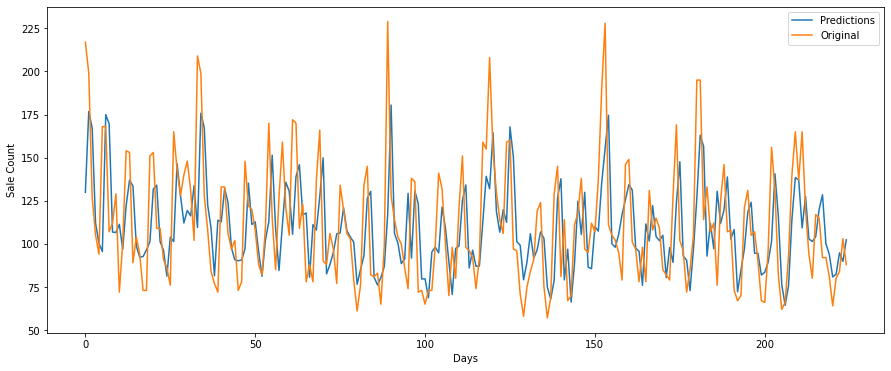

In [291]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = reg.predict(x_test)

plt.figure(figsize=(15,6))
plt.plot(ar_predictions ,label = "Predictions")
plt.plot(y_test, label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, ar_predictions))
print('RMSE: %f' % np.sqrt(np.mean((y_test-ar_predictions)**2)) )

plt.legend(loc="upper right")


**Определите P и Q.**

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


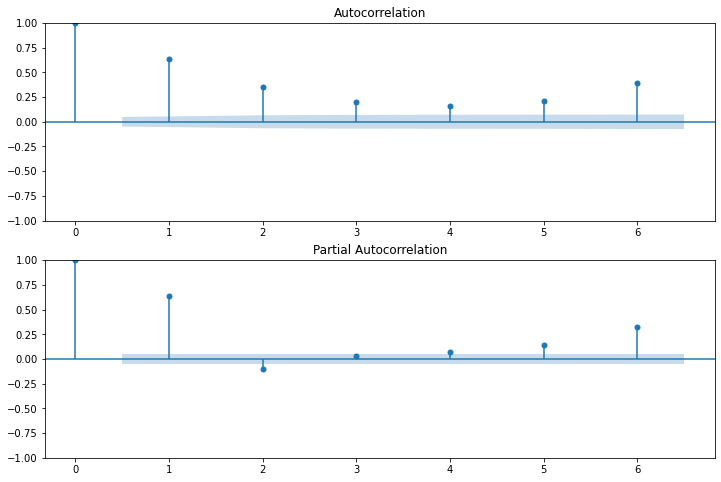

In [292]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(unit_sales_by_date.values.squeeze(), lags=6, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(unit_sales_by_date, lags=6, ax=ax2)

**ARIMA model**

In [293]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

In [294]:
x_train, y_train = df['2013':'2016'].iloc[:,0:lag_value], df['2013':'2016'].iloc[:,lag_value:]
x_test, y_test = df['2017'].iloc[:,0:lag_value], df['2017'].iloc[:,lag_value:]

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


In [295]:
model = ARIMA(endog=x_train.values.reshape(-1).tolist(), order=(6,0,6)).fit()

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


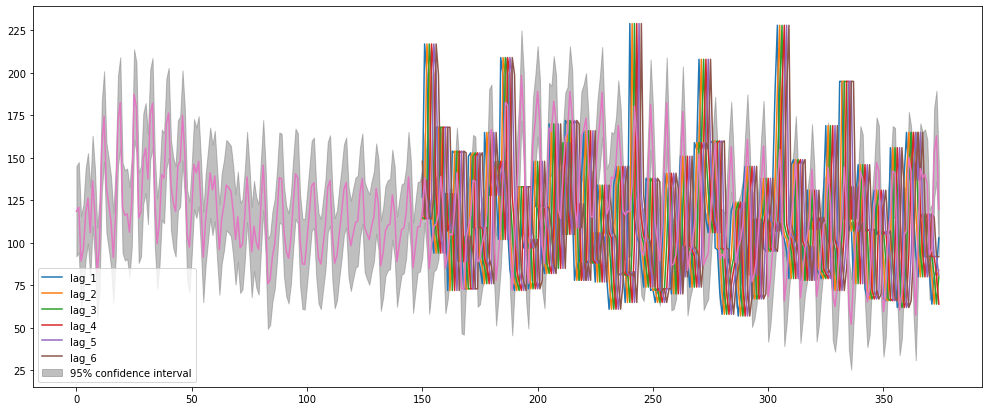

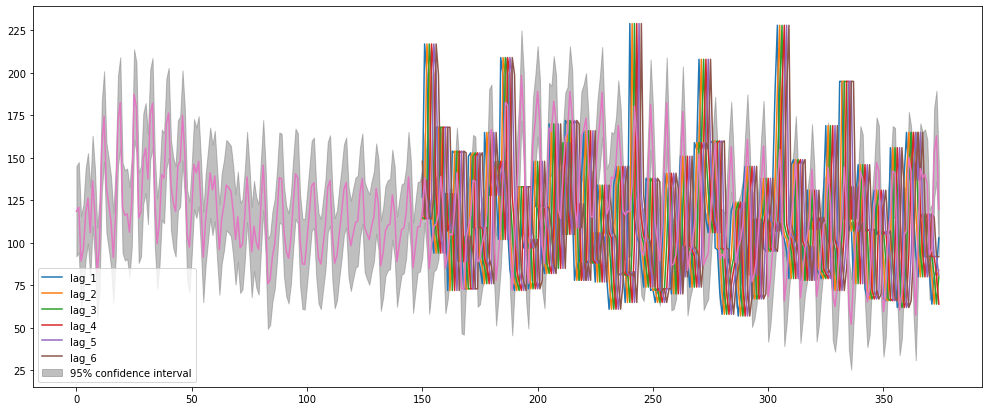

In [296]:
fig, ax = plt.subplots(figsize=(17,7))
shown_train_size = 150
train_size = x_train.shape[0]
test_size = x_test.shape[0]
ax = x_test.set_index(pd.Series(range(shown_train_size, shown_train_size + test_size))).plot(ax=ax)
plot_predict(model, start=train_size-shown_train_size,end=train_size+test_size -1,dynamic=False, plot_insample=True,ax=ax)

mean_squared_error 2192.298978474728
mean_absolute_error 38.009084983698294
mean_absolute_percentage_error 0.36508056406740597


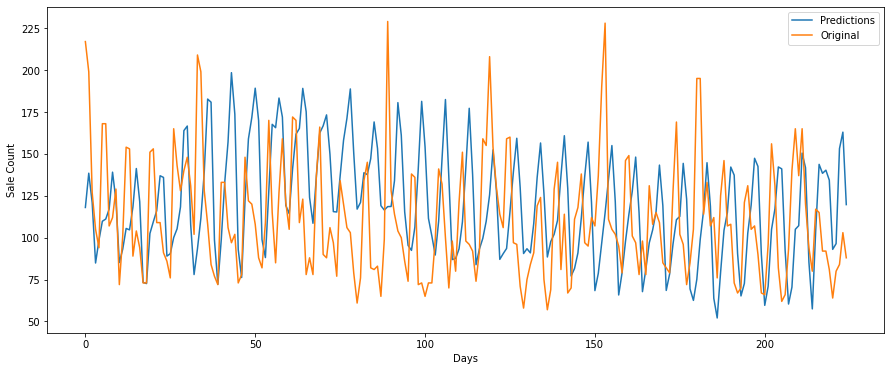

In [297]:
arima_predictions = model.predict(start=len(x_train), end=len(x_train) + len(x_test)-1, dynamic=False)


plt.figure(figsize=(15,6))
plt.plot(arima_predictions ,label = "Predictions")
plt.plot(y_test.values, label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")
plt.legend(loc="upper right")

print("mean_squared_error",mean_squared_error(y_test, arima_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arima_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arima_predictions))

**Вот незря говорят, что ARIMA и SARIMA требует временя на настройки: линейная модель лучше**

In [298]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8358
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -33582.038
Date:                Wed, 15 Jun 2022   AIC                          67192.076
Time:                        17:49:33   BIC                          67290.510
Sample:                             0   HQIC                         67225.695
                               - 8358                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.6489     69.757      1.429      0.153     -37.072     236.370
ar.L1          1.3926      0.024     58.993      0.000       1.346       1.439
ar.L2         -1.5502      0.042    -37.049      0.0

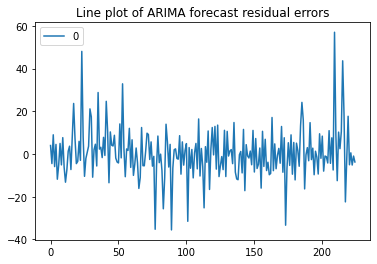

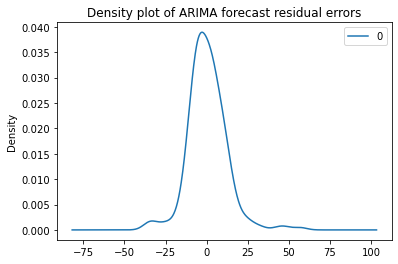

                0
count  225.000000
mean     0.415551
std     11.783341
min    -35.530100
25%     -6.085978
50%     -0.631786
75%      6.666520
max     57.011451


In [299]:
# line plot of residuals
residuals = pd.DataFrame(model.resid[len(x_train):len(x_train) + len(x_test)])
residuals.plot()
plt.title('Line plot of ARIMA forecast residual errors')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Density plot of ARIMA forecast residual errors')
plt.show()
# summary stats of residuals
print(residuals.describe())

**Решетка для подбора параметров ARIMA**

In [300]:
def evaluate_arima_model(df, arima_order):
    # prepare training dataset
            
    x_train, y_train = df['2013':'2016'].iloc[:,0:lag_value], df['2013':'2016'].iloc[:,lag_value:]
    x_test, y_test = df['2017'].iloc[:,0:lag_value], df['2017'].iloc[:,lag_value:]
    
    ARMA_model = ARIMA(endog=x_train.values.reshape(-1).tolist(), order=arima_order).fit()
    arma_predictions = ARMA_model.predict(start=len(x_train), end=len(x_train) + len(x_test)-1, dynamic=False)

    # calculate out-of-sample error
    mape = mean_absolute_percentage_error(y_test, arma_predictions)
    return mape

In [301]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(df, p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                #print(order)
                try:
                    print(order)
                    mape = evaluate_arima_model(df, order)
                    if mape < best_score:
                        best_score, best_cfg = mape, order
                    print('ARIMA%s mape=%.3f' % (order,mape))
                except:
                    continue
    print('Best ARIMA%s mape=%.3f' % (best_cfg, best_score))

In [302]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(1, 7)
q_values = range(0, 7)
evaluate_models(df, p_values, d_values, q_values)

(0, 1, 0)
ARIMA(0, 1, 0) mape=0.460
(0, 1, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(0, 1, 1) mape=0.333
(0, 1, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 2) mape=0.349
(0, 1, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(0, 1, 3) mape=0.353
(0, 1, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(0, 1, 4) mape=0.325
(0, 1, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 5) mape=0.446
(0, 1, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 6) mape=0.398
(0, 2, 0)
ARIMA(0, 2, 0) mape=0.610
(0, 2, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(0, 2, 1) mape=0.460
(0, 2, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 2) mape=0.333
(0, 2, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 3) mape=0.347
(0, 2, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 4) mape=0.301
(0, 2, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 2, 5) mape=0.340
(0, 2, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 2, 6) mape=0.332
(0, 3, 0)
ARIMA(0, 3, 0) mape=0.747
(0, 3, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 3, 1) mape=0.610
(0, 3, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(0, 3, 2) mape=0.462
(0, 3, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 3, 3) mape=0.328
(0, 3, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 3, 4) mape=0.348
(0, 3, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 3, 5) mape=0.539
(0, 3, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 3, 6) mape=0.356
(0, 4, 0)
ARIMA(0, 4, 0) mape=1.123
(0, 4, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 4, 1) mape=0.747
(0, 4, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 4, 2) mape=0.611
(0, 4, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 4, 3) mape=0.462
(0, 4, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 4, 4) mape=0.592
(0, 4, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 4, 5) mape=3.764
(0, 4, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 4, 6) mape=58730.012
(0, 5, 0)
ARIMA(0, 5, 0) mape=1.987
(0, 5, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 5, 1) mape=1.123
(0, 5, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `

ARIMA(0, 5, 2) mape=0.748
(0, 5, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 5, 3) mape=0.611
(0, 5, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 5, 4) mape=0.584
(0, 5, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 5, 5) mape=0.592
(0, 5, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 5, 6) mape=0.612
(0, 6, 0)
ARIMA(0, 6, 0) mape=3.767
(0, 6, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 6, 1) mape=1.988
(0, 6, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 6, 2) mape=1.124
(0, 6, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 6, 3) mape=0.748
(0, 6, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 6, 4) mape=1.001
(0, 6, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 6, 5) mape=0.658
(0, 6, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 6, 6) mape=0.609
(1, 1, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 1, 0) mape=0.456
(1, 1, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 1) mape=0.361
(1, 1, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 2) mape=0.350
(1, 1, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 1, 3) mape=0.306
(1, 1, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 4) mape=0.317
(1, 1, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 5) mape=0.440
(1, 1, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 6) mape=0.404
(1, 2, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 2, 0) mape=0.591
(1, 2, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 2, 1) mape=0.456
(1, 2, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 2) mape=0.460
(1, 2, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 3) mape=0.347
(1, 2, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 2, 4) mape=0.347
(1, 2, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 2, 5) mape=0.497
(1, 2, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 2, 6) mape=0.463
(1, 3, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 3, 0) mape=0.703
(1, 3, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 3, 1) mape=0.591
(1, 3, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 3, 2) mape=0.457
(1, 3, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 3, 3) mape=0.460
(1, 3, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 3, 4) mape=0.329
(1, 3, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 3, 5) mape=0.407
(1, 3, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 3, 6) mape=0.538
(1, 4, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 4, 0) mape=0.816
(1, 4, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 4, 1) mape=0.703
(1, 4, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 4, 2) mape=0.592
(1, 4, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 4, 3) mape=0.609
(1, 4, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 4, 4) mape=0.462
(1, 4, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 4, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 4, 6) mape=0.360
(1, 5, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 5, 0) mape=1.252
(1, 5, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 5, 1) mape=0.816
(1, 5, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 5, 2) mape=0.703
(1, 5, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 5, 3) mape=174755149.749
(1, 5, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 5, 4) mape=0.611
(1, 5, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 5, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 5, 6) mape=2615696.858
(1, 6, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 6, 0) mape=2.111
(1, 6, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 6, 1) mape=1.253
(1, 6, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 6, 2) mape=0.817
(1, 6, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(1, 6, 3) mape=0.704
(1, 6, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 6, 4) mape=0.748
(1, 6, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 6, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 6, 6) mape=0.506
(2, 1, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 1, 0) mape=0.426
(2, 1, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) mape=0.328
(2, 1, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) mape=0.352
(2, 1, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 1, 3) mape=0.359
(2, 1, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 1, 4) mape=0.317
(2, 1, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 5) mape=0.345
(2, 1, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 6) mape=0.367
(2, 2, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 2, 0) mape=0.574
(2, 2, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 2, 1) mape=0.426
(2, 2, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:

ARIMA(2, 2, 2) mape=0.451
(2, 2, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 2, 3) mape=0.456
(2, 2, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 4) mape=0.485
(2, 2, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 2, 5) mape=0.511
(2, 2, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 2, 6) mape=0.427
(2, 3, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 3, 0) mape=0.716
(2, 3, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 3, 1) mape=0.574
(2, 3, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 3, 2) mape=0.586
(2, 3, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 3, 3) mape=0.456
(2, 3, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 3, 4) mape=340313971.555
(2, 3, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 3, 5) mape=0.552
(2, 3, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 3, 6) mape=0.518
(2, 4, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 4, 0) mape=0.751
(2, 4, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 4, 1) mape=0.716
(2, 4, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 4, 2) mape=0.575
(2, 4, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 4, 3) mape=0.589
(2, 4, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 4, 4) mape=0.559
(2, 4, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 4, 5) mape=0.466
(2, 4, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 4, 6) mape=0.323
(2, 5, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 5, 0) mape=0.977
(2, 5, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 5, 1) mape=0.751
(2, 5, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 5, 2) mape=0.717
(2, 5, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 5, 3) mape=0.584
(2, 5, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 5, 4) mape=0.589
(2, 5, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 5, 5) mape=0.602
(2, 5, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 5, 6) mape=0.462
(2, 6, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 6, 0) mape=1.599
(2, 6, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(2, 6, 1) mape=0.977
(2, 6, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 6, 2) mape=0.751
(2, 6, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 6, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 6, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 6, 5) mape=0.654
(2, 6, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 6, 6) mape=0.593
(4, 1, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 1, 0) mape=0.359
(4, 1, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 1, 1) mape=0.343
(4, 1, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 1, 2) mape=0.333
(4, 1, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 1, 3) mape=0.361
(4, 1, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 1, 4) mape=0.370
(4, 1, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 1, 5) mape=0.353
(4, 1, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 1, 6) mape=0.375
(4, 2, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 2, 0) mape=0.512
(4, 2, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 2, 1) mape=0.359
(4, 2, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 2, 2) mape=0.376
(4, 2, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 2, 3) mape=0.401
(4, 2, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 2, 4) mape=0.467
(4, 2, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 2, 5) mape=0.477
(4, 2, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 2, 6) mape=0.392
(4, 3, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 3, 0) mape=0.703
(4, 3, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 3, 1) mape=0.512
(4, 3, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 3, 2) mape=0.527
(4, 3, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 3, 3) mape=0.531
(4, 3, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 3, 4) mape=0.572
(4, 3, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 3, 5) mape=0.553
(4, 3, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 3, 6) mape=0.461
(4, 4, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 4, 0) mape=0.819
(4, 4, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 4, 1) mape=0.703
(4, 4, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 4, 2) mape=0.689
(4, 4, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 4, 3) mape=0.646
(4, 4, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 4, 4) mape=0.543
(4, 4, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 4, 5) mape=0.585
(4, 4, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 4, 6) mape=0.548
(4, 5, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 5, 0) mape=0.728
(4, 5, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 5, 1) mape=0.819
(4, 5, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 5, 2) mape=0.756
(4, 5, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 5, 3) mape=0.683
(4, 5, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 5, 4) mape=0.610
(4, 5, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 5, 5) mape=0.512
(4, 5, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 5, 6) mape=0.569
(4, 6, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 6, 0) mape=0.570
(4, 6, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 6, 1) mape=0.728
(4, 6, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(4, 6, 2) mape=0.681
(4, 6, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 6, 3) mape=0.566
(4, 6, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 6, 4) mape=0.666
(4, 6, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 6, 5) mape=0.571
(4, 6, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(4, 6, 6) mape=0.514
(6, 1, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 1, 0) mape=0.367
(6, 1, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a futu

ARIMA(6, 1, 1) mape=0.368
(6, 1, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 1, 2) mape=0.367
(6, 1, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 1, 3) mape=0.367
(6, 1, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 1, 4) mape=0.363
(6, 1, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 1, 5) mape=0.367
(6, 1, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 1, 6) mape=0.371
(6, 2, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 2, 0) mape=0.377
(6, 2, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 2, 1) mape=0.369
(6, 2, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 2, 2) mape=0.368
(6, 2, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 2, 3) mape=0.375
(6, 2, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 2, 4) mape=0.374
(6, 2, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 2, 5) mape=0.378
(6, 2, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 2, 6) mape=0.371
(6, 3, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 3, 0) mape=0.448
(6, 3, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 3, 1) mape=0.377
(6, 3, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 3, 2) mape=0.379
(6, 3, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 3, 3) mape=0.369
(6, 3, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 3, 4) mape=0.372
(6, 3, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 3, 5) mape=0.382
(6, 3, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 3, 6) mape=0.386
(6, 4, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 4, 0) mape=0.617
(6, 4, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(6, 4, 1) mape=0.422
(6, 4, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 4, 2) mape=0.378
(6, 4, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 4, 3) mape=0.378
(6, 4, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 4, 4) mape=0.376
(6, 4, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 4, 5) mape=0.382
(6, 4, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 4, 6) mape=0.382
(6, 5, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 5, 0) mape=0.695
(6, 5, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 5, 1) mape=0.613
(6, 5, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 5, 2) mape=0.421
(6, 5, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 5, 3) mape=0.378
(6, 5, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 5, 4) mape=0.376
(6, 5, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 5, 5) mape=0.560
(6, 5, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 5, 6) mape=0.602
(6, 6, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(6, 6, 0) mape=0.645
(6, 6, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 6, 1) mape=0.700
(6, 6, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(6, 6, 2) mape=0.600
(6, 6, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 6, 3) mape=0.422
(6, 6, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 6, 4) mape=0.578
(6, 6, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 6, 5) mape=0.537
(6, 6, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(6, 6, 6) mape=0.574
(8, 1, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(8, 1, 0) mape=0.367
(8, 1, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 1, 1) mape=0.367
(8, 1, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 1, 2) mape=0.368
(8, 1, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 1, 3) mape=0.372
(8, 1, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 1, 4) mape=0.378
(8, 1, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 1, 5) mape=0.378
(8, 1, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 1, 6) mape=0.372
(8, 2, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(8, 2, 0) mape=0.360
(8, 2, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 2, 1) mape=0.369
(8, 2, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 2, 2) mape=0.375
(8, 2, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 2, 3) mape=0.371
(8, 2, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 2, 4) mape=0.372
(8, 2, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 2, 5) mape=0.382
(8, 2, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 2, 6) mape=0.374
(8, 3, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(8, 3, 0) mape=0.378
(8, 3, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 3, 1) mape=0.367
(8, 3, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 3, 2) mape=0.377
(8, 3, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 3, 3) mape=0.374
(8, 3, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 3, 4) mape=0.377
(8, 3, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 3, 5) mape=0.377
(8, 3, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 3, 6) mape=0.372
(8, 4, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(8, 4, 0) mape=0.447
(8, 4, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 4, 1) mape=0.373
(8, 4, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 4, 2) mape=1.000
(8, 4, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 4, 3) mape=0.370
(8, 4, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 4, 4) mape=0.375
(8, 4, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 4, 5) mape=0.377
(8, 4, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 4, 6) mape=0.378
(8, 5, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(8, 5, 0) mape=0.567
(8, 5, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 5, 1) mape=0.434
(8, 5, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 5, 2) mape=0.361
(8, 5, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(8, 5, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(8, 5, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 5, 5) mape=0.378
(8, 5, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(8, 5, 6) mape=105718344799.854
(8, 6, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(8, 6, 0) mape=0.645
(8, 6, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 6, 1) mape=0.561
(8, 6, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 6, 2) mape=0.461
(8, 6, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(8, 6, 3) mape=0.499
(8, 6, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 6, 4) mape=0.428
(8, 6, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using ze

ARIMA(8, 6, 5) mape=0.423
(8, 6, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(8, 6, 6) mape=0.374
(10, 1, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(10, 1, 0) mape=0.367
(10, 1, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 1, 1) mape=0.372
(10, 1, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 1, 2) mape=0.374
(10, 1, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 1, 3) mape=0.375
(10, 1, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 1, 4) mape=0.373
(10, 1, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 1, 5) mape=0.375
(10, 1, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 1, 6) mape=0.374
(10, 2, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(10, 2, 0) mape=0.366
(10, 2, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 2, 1) mape=0.371
(10, 2, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 2, 2) mape=0.374
(10, 2, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 2, 3) mape=0.369
(10, 2, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 2, 4) mape=0.375
(10, 2, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 2, 5) mape=0.371
(10, 2, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 2, 6) mape=0.377
(10, 3, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(10, 3, 0) mape=0.369
(10, 3, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 3, 1) mape=0.368
(10, 3, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 3, 2) mape=0.385
(10, 3, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 3, 3) mape=0.366
(10, 3, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 3, 4) mape=0.366
(10, 3, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 3, 5) mape=0.368
(10, 3, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 3, 6) mape=0.368
(10, 4, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(10, 4, 0) mape=0.414
(10, 4, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 4, 1) mape=0.368
(10, 4, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 4, 2) mape=0.370
(10, 4, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 4, 3) mape=0.374
(10, 4, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 4, 4) mape=0.373
(10, 4, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(10, 4, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 4, 6) mape=0.365
(10, 5, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


ARIMA(10, 5, 0) mape=0.479
(10, 5, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 5, 1) mape=0.426
(10, 5, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 5, 2) mape=0.373
(10, 5, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 5, 3) mape=0.417
(10, 5, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 5, 4) mape=0.373
(10, 5, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 5, 5) mape=0.369
(10, 5, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 5, 6) mape=0.369
(10, 6, 0)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 6, 0) mape=0.559
(10, 6, 1)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 6, 1) mape=0.574
(10, 6, 2)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 6, 2) mape=0.487
(10, 6, 3)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(10, 6, 4)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 6, 4) mape=0.419
(10, 6, 5)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 6, 5) mape=0.378
(10, 6, 6)


C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(10, 6, 6) mape=0.361
Best ARIMA(0, 2, 4) mape=0.301


**Для модели ARIMA наилучшие параметры Best ARIMA(0, 2, 4) mape=0.301, что насамом деле не являются далеко лучшим результатом.**

# МОДУЛЬ 15. ПРОЕКТ МОДУЛЯ (HW-03)(часть 2) FPProphet

Ноутбук с пророком доступен в colab на google.com
https://colab.research.google.com/drive/15agZbcOEbGDSo-RaHOVW87EoHT8NX31K?usp=sharing

Для Пророка от Фейсбука метрика на тестовом наборе получена 0.14